In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from torchinfo import summary
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm.auto import tqdm

from datetime import datetime

from PIL import Image
import os
from pathlib import Path
from typing import Tuple, Dict, List

from torch.utils.tensorboard import SummaryWriter

print(f"pytorch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

pytorch version: 2.5.1+cu118
torchvision version: 0.20.1+cpu


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
def create_writer(experiment_name: str,
                  model_name: str,
                  extra: str=None):
    
    timestamp = datetime.now().strftime("%Y-%m-%d")
    if extra:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
    return SummaryWriter(log_dir=log_dir)

In [5]:
writer = create_writer(experiment_name="pretrained_vit_second",
                               model_name="pretrained_vit",
                               extra="5_epochs")

In [6]:
def set_seed(seed: int=42):
    """ Sets random seed for torch operations.
    Args:
        seed (int) : random seed to set.
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [7]:
data_path = Path("../dataset/")
image_path = data_path / "data"

In [8]:
train_dir = image_path / "train_dir"
test_dir = image_path / "test_dir"

train_dir, test_dir

(WindowsPath('../dataset/data/train_dir'),
 WindowsPath('../dataset/data/test_dir'))

In [9]:
for entry in os.scandir(str(train_dir)):
    if entry.is_dir():
        print(entry.name)

daisy
dandelion
rose
sunflower
tulip


In [10]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """ Finds subdirectories in the given directory and maps class names to indices.

    Args:
        directory (str):  Path to the directory

    Returns:
        Tuple[List[str], Dict[str, int]]
        * A sorted list of class names
        * A dictionary mapping class names to unique indices
    """
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")

    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}

    return classes, class_to_idx

In [11]:
classes, class_to_idx = find_classes(train_dir)
classes, class_to_idx

(['daisy', 'dandelion', 'rose', 'sunflower', 'tulip'],
 {'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4})

In [12]:
paths = list(Path(train_dir).glob("*/*.jpg"))
print(len(paths))

3453


In [13]:
class ImageFolder(Dataset):
    def __init__(self, target_dir: str, transform=None) -> None:
        self.paths = list(Path(target_dir).glob("*/*.jpg"))
        self.transform = transform
        self.classes, self.class_to_idx = find_classes(target_dir)

    def load_image(self, index: int) -> Image.Image:
        image_path = self.paths[index]
        return Image.open(image_path)

    def __len__(self) -> int:
        return len(self.paths)

    def __getitem__(self, index: int):
        img = self.load_image(index)
        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]

        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx

In [14]:

def create_dataloaders(train_dir: str,
                       test_dir: str,
                       transform: transforms.Compose,
                       batch_size: int,
                       ):
    """Creates training and testing DataLoaders.

    Args:
        train_dir (str) : path to training directory
        test_dir (str) : path to testing directory
        transform : torchvision transforms to perform on training and testing data.
        batch_size: Number of samples per batch
        num_workers : An integer for number of workers per DataLoader.
   
    Returns:
        A tuple of (train_dataloader, test_dataloader, class_names).
    """

    train_data = ImageFolder(train_dir, transform=transform)
    test_data = ImageFolder(test_dir, transform=transform)

    class_names = train_data.classes

    train_dataloader = DataLoader(train_data,
                                 batch_size=batch_size,
                                 shuffle=True,
                                 pin_memory=True)
    
    test_dataloader = DataLoader(test_data,
                                batch_size=batch_size,
                                shuffle=True,
                                pin_memory=True)

    return train_dataloader, test_dataloader, class_names
    

In [15]:
#get pretrained weights 
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

for parameter in pretrained_vit.parameters():
    parameter.requires_grad=False

#set_seed()
pretrained_vit.heads = nn.Linear(in_features=768,
                                 out_features=len(classes)).to(device)


In [16]:
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [17]:
train_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=train_dir,
                                                                   test_dir=test_dir,
                                                                   transform=pretrained_vit_transforms,
                                                                   batch_size=32)

In [18]:
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 5]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [19]:
def train_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer,
              device: torch.device):

    """ Perform a single training step for a pytorch model.

    Args:
        model : the neural network model to train.
        dataloader : dataloader providing the training data in batches.
        loss_fn : the loss function to evaluate the model's predictions.
        optimizer : the optimizer to update the model's parameters.
        device: target device
    Returns:
        tuple: 
            *train_loss (float) :  The average loss over the training set.
            *train_acc (float) : The average accuracy over the training set.
    """

    #put model in train mode
    model.train()

    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        #send data to target device
        X, y = X.to(device), y.to(device)

        #forward pass
        y_pred = model(X)

        # calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        #optimizer zero grad
        optimizer.zero_grad()

        #loss backward
        loss.backward()

        #optimizer step
        optimizer.step()

        #calculate and acc metric
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

In [20]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn : torch.nn.Module,
              device: torch.device):

    """ Performs a single evaluation step for a PyTorch model.

    Args:
        model : the neural network model to evaluate.
        dataloader : DataLoader providing the test/validation data in batches.
        loss_fn : The loss function to evaluate the model's predictions.
        device: the target device.

    Returns: 
        tuple : 
            * test_loss (float) : The average loss over the test set.
            * test_acc (float) : The average accuracy over the test set.
    """

    
    #put model in eval mode
    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            #send data to target device
            X, y = X.to(device), y.to(device)

            #forward pass
            test_pred_logits = model(X)

            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

        test_loss = test_loss / len(dataloader)
        test_acc = test_acc / len(dataloader)

        return test_loss, test_acc

In [21]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
         writer: torch.utils.tensorboard.writer.SummaryWriter):
    """Trains and tests a PyTorch model.
    """

    results = {"train_loss" : [],
              "train_acc" : [],
              "test_loss" : [],
              "test_acc": []
              }

    #loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn, 
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                       dataloader=test_dataloader,
                                       loss_fn=loss_fn,
                                       device=device)

        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
          )

          # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        writer.add_scalars("Accuracy",
                           {"train_acc": train_acc, "test_acc": test_acc},
                           epoch)
        writer.add_scalars("Loss",
                           {"train_loss": train_loss, "test_loss": test_loss},
                           epoch)
        if epoch == 0:  
            writer.add_graph(model=model,
                             input_to_model=torch.randn(32, 3, 224, 224).to(device))

 
    return results   

In [22]:
torch.manual_seed(42)

set_seed()

optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss()

pretrained_vit_results = train(model=pretrained_vit,
                              train_dataloader=train_dataloader,
                              test_dataloader=test_dataloader,
                              optimizer=optimizer,
                              loss_fn=loss_fn,
                              epochs=5,
                              device=device,
                              writer=writer)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5536 | train_acc: 0.8281 | test_loss: 0.2793 | test_acc: 0.9282


C:\Users\aysen\anaconda3\envs\pytorch\lib\site-packages\torch\__init__.py:2040: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert condition, message


Epoch: 2 | train_loss: 0.2780 | train_acc: 0.9213 | test_loss: 0.2184 | test_acc: 0.9387
Epoch: 3 | train_loss: 0.2222 | train_acc: 0.9375 | test_loss: 0.1906 | test_acc: 0.9433
Epoch: 4 | train_loss: 0.1883 | train_acc: 0.9440 | test_loss: 0.1755 | test_acc: 0.9491
Epoch: 5 | train_loss: 0.1640 | train_acc: 0.9545 | test_loss: 0.1735 | test_acc: 0.9468


In [23]:
def plot_curves(results: Dict[str, List[float]]):
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("loss")
    plt.xlabel("epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("accuracy")
    plt.xlabel("epochs")
    plt.legend()
    

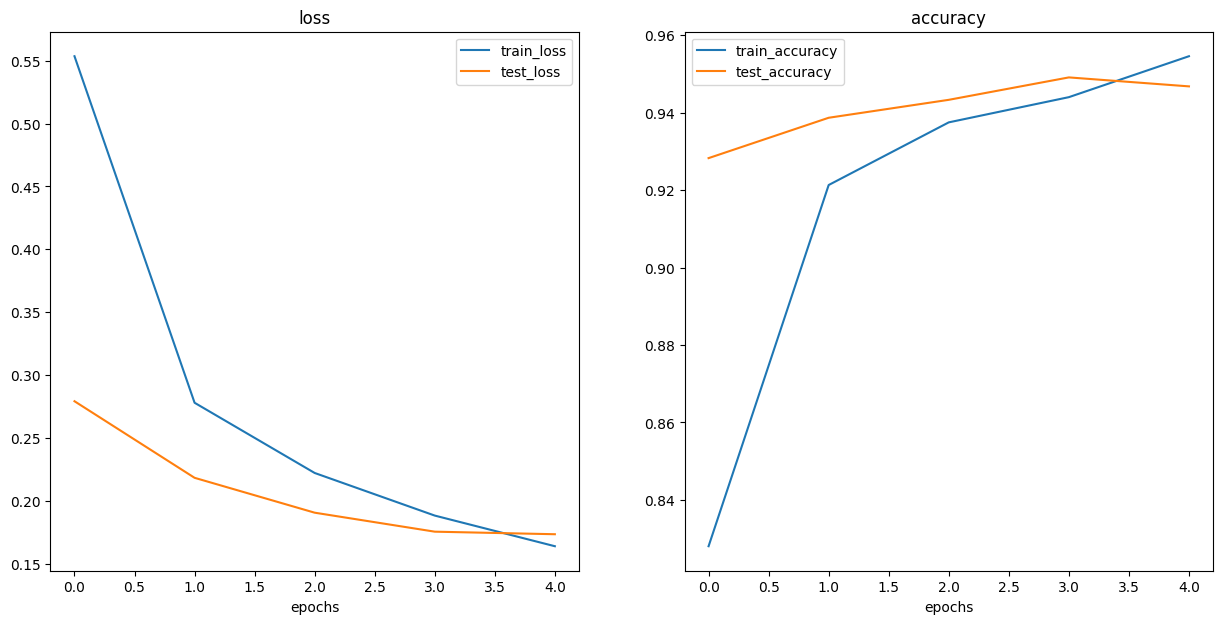

In [24]:
plot_curves(pretrained_vit_results)

In [25]:
#custom image path

custom_image_path = "../img/lale.jpg"
print(custom_image_path)

../img/lale.jpg


In [26]:
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

custom_image = custom_image / 255


print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image shape: torch.Size([3, 853, 1280])

Custom image dtype: torch.float32


(np.float64(-0.5), np.float64(1279.5), np.float64(852.5), np.float64(-0.5))

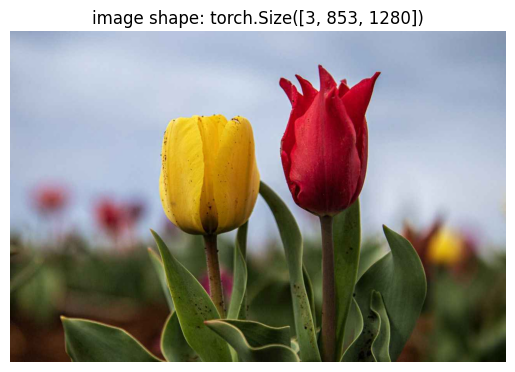

In [27]:
plt.imshow(custom_image.permute(1, 2, 0))
plt.title(f"image shape: {custom_image.shape}")
plt.axis(False)

In [28]:
custom_image_transformed = pretrained_vit_transforms(custom_image)

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 853, 1280])
New shape: torch.Size([3, 224, 224])


In [29]:
pretrained_vit.eval()

with torch.inference_mode():
    custom_image_transformed = custom_image_transformed.unsqueeze(dim=0)
    print(f"custom image transformed shape: {custom_image_transformed.shape}")

    custom_image_pred = pretrained_vit(custom_image_transformed.to(device))

custom image transformed shape: torch.Size([1, 3, 224, 224])


In [30]:
custom_image_pred

tensor([[-4.1386, -4.2241,  0.8529, -2.0354,  7.3576]], device='cuda:0')

In [31]:
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_probs

tensor([[1.0153e-05, 9.3211e-06, 1.4941e-03, 8.3177e-05, 9.9840e-01]],
       device='cuda:0')

In [32]:
custom_image_pred_labels = torch.argmax(custom_image_pred_probs, dim=1)
custom_image_pred_labels

tensor([4], device='cuda:0')

In [33]:
custom_image_pred_class = class_names[custom_image_pred_labels]
custom_image_pred_class

'tulip'

In [34]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int]=(224,224),
                        transform: torchvision.transforms=None,
                        device: torch.device=device):

    #open image
    img = Image.open(image_path)

    if transform is not None:
        image_transform = transform
    else:
         image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    model.to(device)

    model.eval()

    with torch.inference_mode():
        transformed_image = image_transform(img).unsqueeze(dim=0)

        image_pred = model(transformed_image.to(device))


    image_pred_probs = torch.softmax(image_pred, dim=1)
    image_pred_label = torch.argmax(image_pred_probs, dim=1)

    plt.figure()
    plt.imshow(img)
    plt.title(f"pred: {class_names[image_pred_label]} prob: {image_pred_probs.max()}")
    plt.axis(False)
        
        

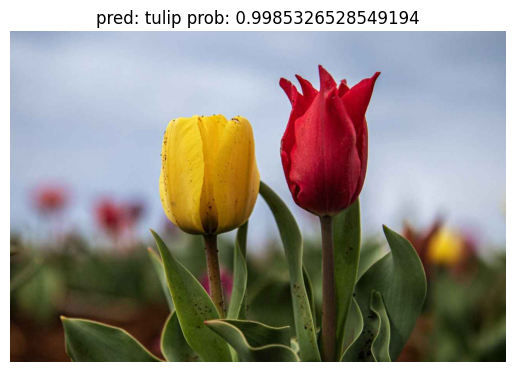

In [35]:
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

In [41]:
#%load_ext tensorboard 
#%tensorboard --logdir runs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [42]:
def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):

    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True,
                          exist_ok=True)

    assert model_name.endswith(".pth") or model_name.endswith(".pt")
    model_save_path = target_dir_path / model_name

    print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(),
                 f=model_save_path)

In [43]:
save_model(model=pretrained_vit,
           target_dir="models",
           model_name="01_pretrained_vit_flower_classification.pth")

[INFO] Saving model to: models\01_pretrained_vit_flower_classification.pth


In [44]:
#get the model size in bytes then convert to megabytes

pretrained_vit_model_size = Path("models/01_pretrained_vit_flower_classification.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB
